In [172]:
import bayesflow.diagnostics as diag
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import InvertibleNetwork, SequenceNetwork
from bayesflow.simulation import GenerativeModel, Prior, Simulator
from bayesflow.trainers import Trainer

import numpy as np
import pickle
from SlovotvirModel import run_model
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import arviz as az
from tabulate import tabulate

In [39]:
RNG = np.random.default_rng(2023)

In [40]:
x = run_model((10, 0, 1))

### 0. Setup and training

In [41]:
def model_prior():
    """Generates a random draw from the joint prior."""

    a = RNG.uniform(0, 10)
    b = RNG.uniform(0, 10)
    t = RNG.lognormal(0, sigma=0.5)
    return np.array([a, b, t])

In [42]:
prior = Prior(prior_fun=model_prior, param_names=[r"a", r"b", r"t"])

In [43]:
prior_means, prior_stds = prior.estimate_means_and_stds()

In [44]:
simulator = Simulator(simulator_fun=run_model)

In [45]:
model = GenerativeModel(prior, simulator, name="SlovoTvir")

INFO:root:Performing 2 pilot runs with the SlovoTvir model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


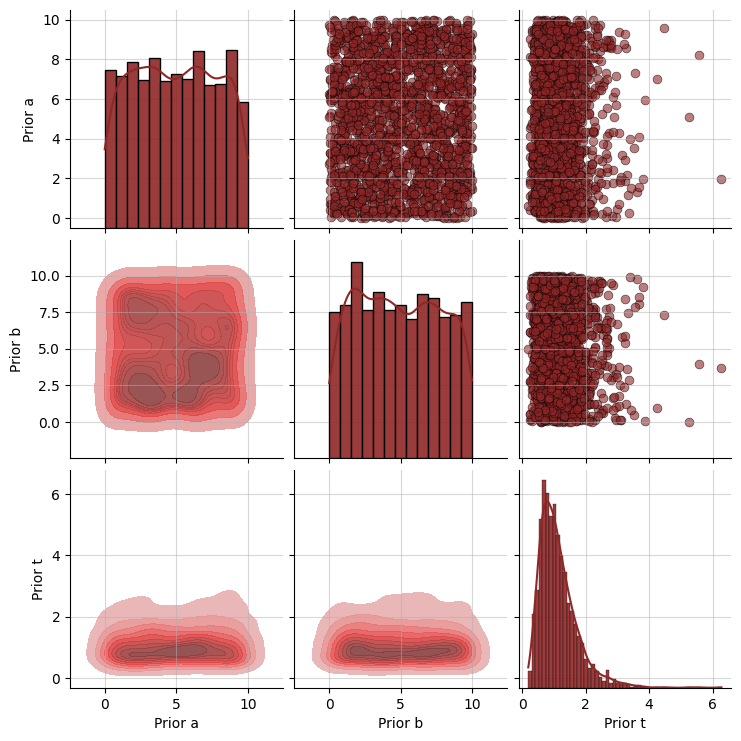

In [46]:
# As per default, the plot_prior2d function will obtain 1000 draws from the joint prior.
f = prior.plot_prior2d()

In [47]:
summary_net = SequenceNetwork()

In [48]:
inference_net = InvertibleNetwork(num_params=len(prior.param_names), num_coupling_layers=4)

In [49]:
amortizer = AmortizedPosterior(inference_net, summary_net, name="slovotvir_amortizer")

In [50]:
def configure_input(forward_dict):
    """Function to configure the simulated quantities (i.e., simulator outputs)
    into a neural network-friendly (BayesFlow) format.
    """

    # Prepare placeholder dict
    out_dict = {}

    # Convert data to logscale
    logdata = np.log1p(forward_dict["sim_data"]).astype(np.float32)

    # Extract prior draws and z-standardize with previously computed means
    params = forward_dict["prior_draws"].astype(np.float32)
    params = (params - prior_means) / prior_stds

    # Add to keys
    out_dict["summary_conditions"] = logdata
    out_dict["parameters"] = params

    out_dict["summary_conditions"] = np.expand_dims(out_dict["summary_conditions"], axis=2)

    return out_dict

In [51]:
x = configure_input(model(1))

In [52]:
x['summary_conditions'].shape

(1, 100, 1)

In [53]:
trainer = Trainer(amortizer=amortizer, generative_model=model, configurator=configure_input, memory=True)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [54]:
amortizer.summary()

Model: "slovotvir_amortizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network_1 (Inve  multiple                  292936    
 rtibleNetwork)                                                  
                                                                 
 sequence_network_1 (Sequen  multiple                  91178     
 ceNetwork)                                                      
                                                                 
Total params: 384114 (1.47 MB)
Trainable params: 384090 (1.47 MB)
Non-trainable params: 24 (96.00 Byte)
_________________________________________________________________


In [55]:
%%time
gen_data = model(5000)

CPU times: user 4h 40min 33s, sys: 40.6 s, total: 4h 41min 14s
Wall time: 4h 41min 48s


In [74]:
# pickle _
pickle.dump(gen_data, open('data_5000.pickle', 'wb'))
# unpickled = pickle.load(open('data.pickle', 'rb'))

In [57]:
%%time
history = trainer.train_offline(gen_data, epochs=100, batch_size=32, validation_sims=1000)

INFO:root:Generated 1000 simulations for validation.


Training epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 3.903


Training epoch 2:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 3.059


Training epoch 3:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 2.886


Training epoch 4:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 3.315


Training epoch 5:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 2.859


Training epoch 6:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 3.114


Training epoch 7:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 2.614


Training epoch 8:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: 2.923


Training epoch 9:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: 3.053


Training epoch 10:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: 2.827


Training epoch 11:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Loss: 2.708


Training epoch 12:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Loss: 1.933


Training epoch 13:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Loss: 1.770


Training epoch 14:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Loss: 2.040


Training epoch 15:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Loss: 1.647


Training epoch 16:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Loss: 1.456


Training epoch 17:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Loss: 1.807


Training epoch 18:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Loss: 1.722


Training epoch 19:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Loss: 1.419


Training epoch 20:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Loss: 1.362


Training epoch 21:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Loss: 2.473


Training epoch 22:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Loss: 1.937


Training epoch 23:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Loss: 1.522


Training epoch 24:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Loss: 2.108


Training epoch 25:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Loss: 1.218


Training epoch 26:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Loss: 1.308


Training epoch 27:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Loss: 1.187


Training epoch 28:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Loss: 2.192


Training epoch 29:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Loss: 1.289


Training epoch 30:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Loss: 1.295


Training epoch 31:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, Loss: 1.151


Training epoch 32:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, Loss: 1.359


Training epoch 33:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, Loss: 1.091


Training epoch 34:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, Loss: 1.027


Training epoch 35:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, Loss: 1.166


Training epoch 36:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, Loss: 0.879


Training epoch 37:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, Loss: 0.909


Training epoch 38:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, Loss: 0.901


Training epoch 39:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, Loss: 0.807


Training epoch 40:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, Loss: 0.874


Training epoch 41:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, Loss: 0.761


Training epoch 42:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, Loss: 1.133


Training epoch 43:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, Loss: 1.267


Training epoch 44:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, Loss: 0.815


Training epoch 45:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, Loss: 1.311


Training epoch 46:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, Loss: 1.149


Training epoch 47:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, Loss: 0.636


Training epoch 48:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, Loss: 0.662


Training epoch 49:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, Loss: 0.837


Training epoch 50:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, Loss: 1.122


Training epoch 51:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 51, Loss: 0.636


Training epoch 52:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 52, Loss: 0.999


Training epoch 53:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 53, Loss: 0.835


Training epoch 54:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 54, Loss: 0.523


Training epoch 55:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 55, Loss: 0.583


Training epoch 56:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 56, Loss: 0.710


Training epoch 57:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 57, Loss: 0.849


Training epoch 58:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 58, Loss: 0.911


Training epoch 59:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 59, Loss: 0.417


Training epoch 60:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 60, Loss: 0.886


Training epoch 61:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 61, Loss: 0.398


Training epoch 62:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 62, Loss: 0.387


Training epoch 63:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 63, Loss: 0.530


Training epoch 64:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 64, Loss: 0.353


Training epoch 65:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 65, Loss: 0.480


Training epoch 66:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 66, Loss: 0.565


Training epoch 67:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 67, Loss: 0.346


Training epoch 68:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 68, Loss: 0.259


Training epoch 69:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 69, Loss: 0.698


Training epoch 70:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 70, Loss: 0.209


Training epoch 71:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 71, Loss: 0.281


Training epoch 72:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 72, Loss: 0.521


Training epoch 73:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 73, Loss: 0.323


Training epoch 74:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 74, Loss: 0.396


Training epoch 75:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 75, Loss: 0.307


Training epoch 76:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 76, Loss: 0.146


Training epoch 77:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 77, Loss: 0.329


Training epoch 78:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 78, Loss: 0.151


Training epoch 79:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 79, Loss: 0.142


Training epoch 80:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 80, Loss: 0.169


Training epoch 81:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 81, Loss: 0.108


Training epoch 82:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 82, Loss: 0.127


Training epoch 83:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 83, Loss: 0.097


Training epoch 84:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 84, Loss: 0.109


Training epoch 85:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 85, Loss: 0.096


Training epoch 86:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 86, Loss: 0.104


Training epoch 87:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 87, Loss: 0.117


Training epoch 88:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 88, Loss: 0.074


Training epoch 89:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 89, Loss: 0.072


Training epoch 90:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 90, Loss: 0.055


Training epoch 91:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 91, Loss: 0.067


Training epoch 92:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 92, Loss: 0.066


Training epoch 93:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 93, Loss: 0.066


Training epoch 94:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 94, Loss: 0.039


Training epoch 95:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 95, Loss: 0.036


Training epoch 96:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 96, Loss: 0.037


Training epoch 97:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 97, Loss: 0.038


Training epoch 98:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 98, Loss: 0.034


Training epoch 99:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 99, Loss: 0.032


Training epoch 100:   0%|          | 0/157 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 100, Loss: 0.032


CPU times: user 1h 14min 25s, sys: 6min 32s, total: 1h 20min 57s
Wall time: 1h 14min 46s


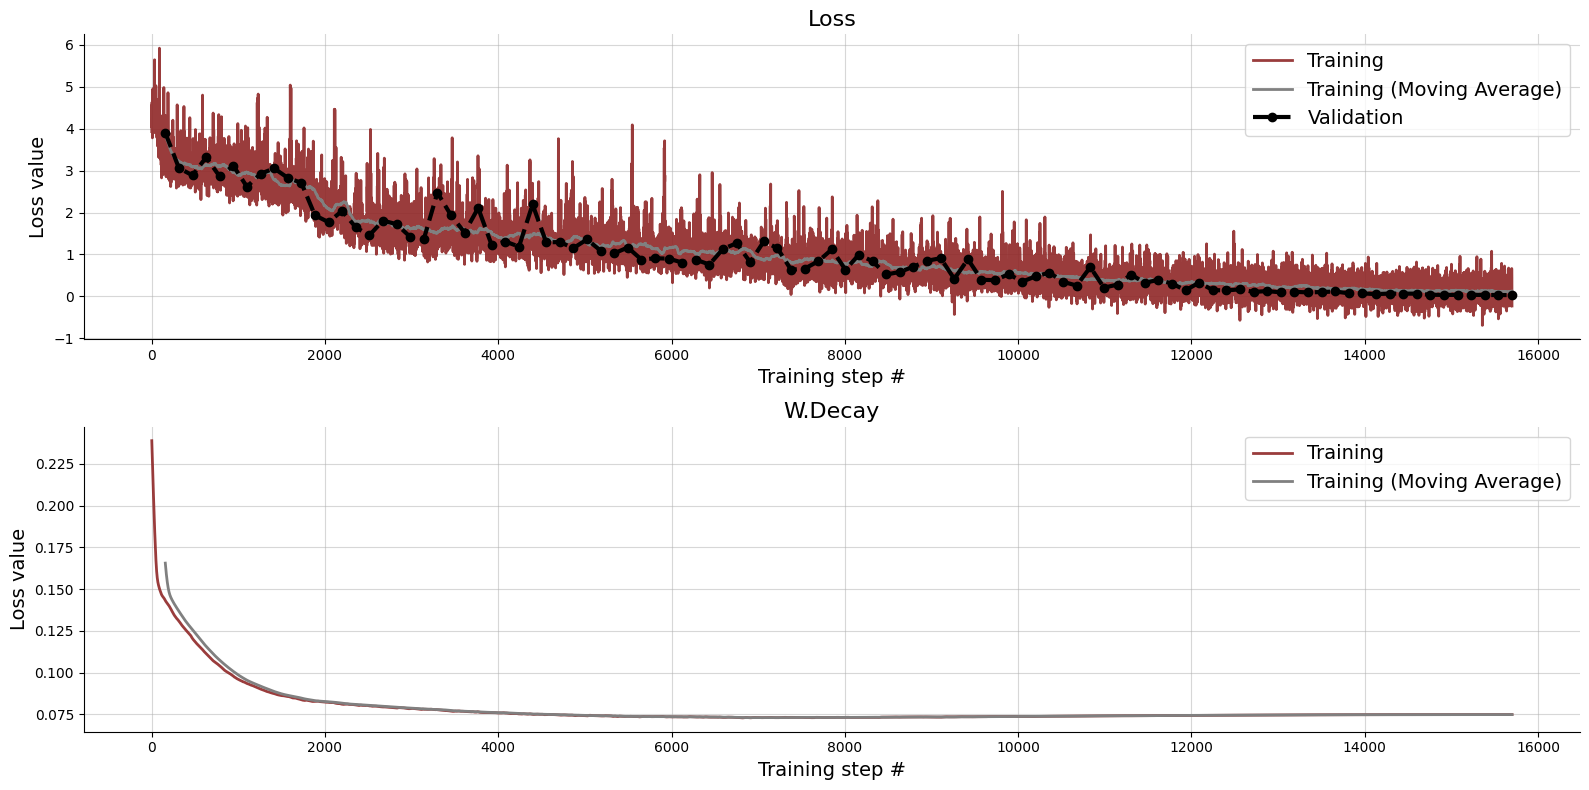

In [58]:
f = diag.plot_losses(history["train_losses"], history["val_losses"], moving_average=True)

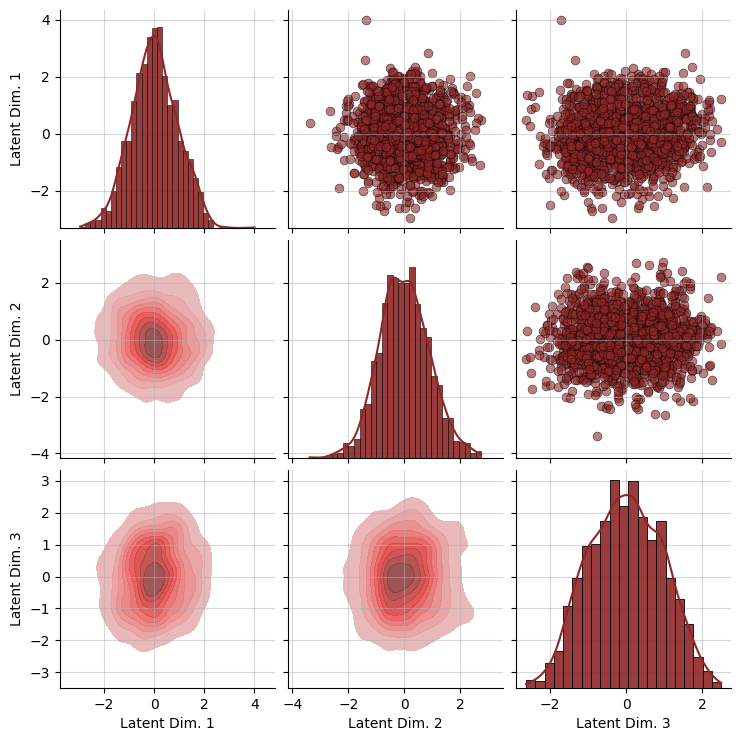

In [59]:
f = trainer.diagnose_latent2d()

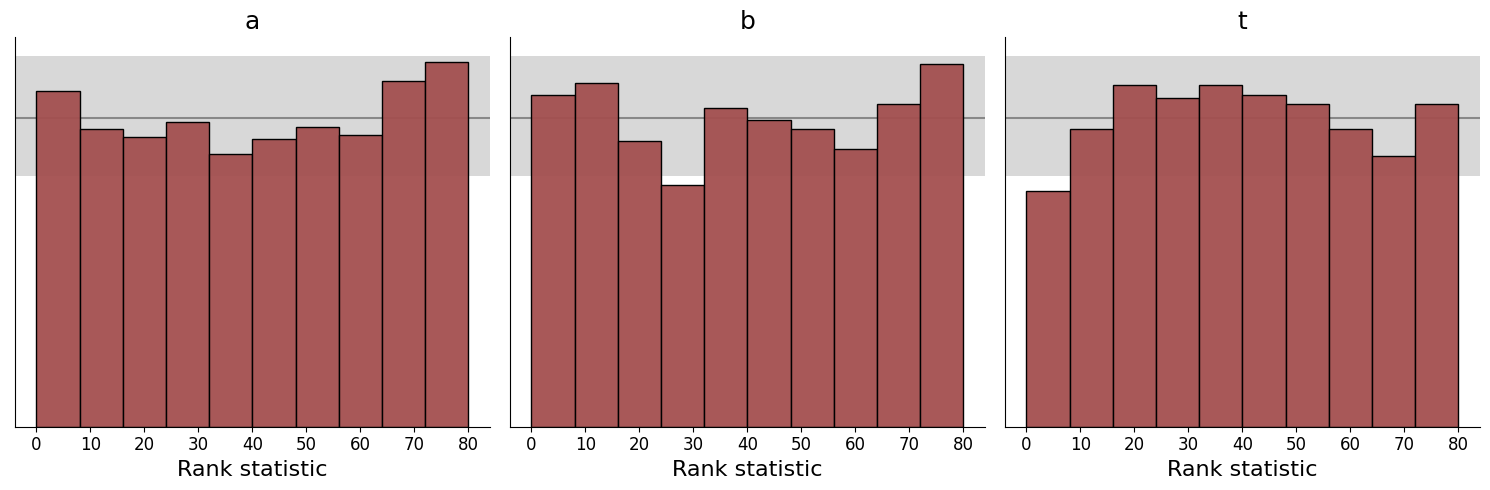

In [60]:
f = trainer.diagnose_sbc_histograms()

In [116]:
# Generate some validation data
validation_sims = trainer.configurator(model(batch_size=100))

In [117]:
# Generate posterior draws for all simulations
post_samples = amortizer.sample(validation_sims, n_samples=1000)

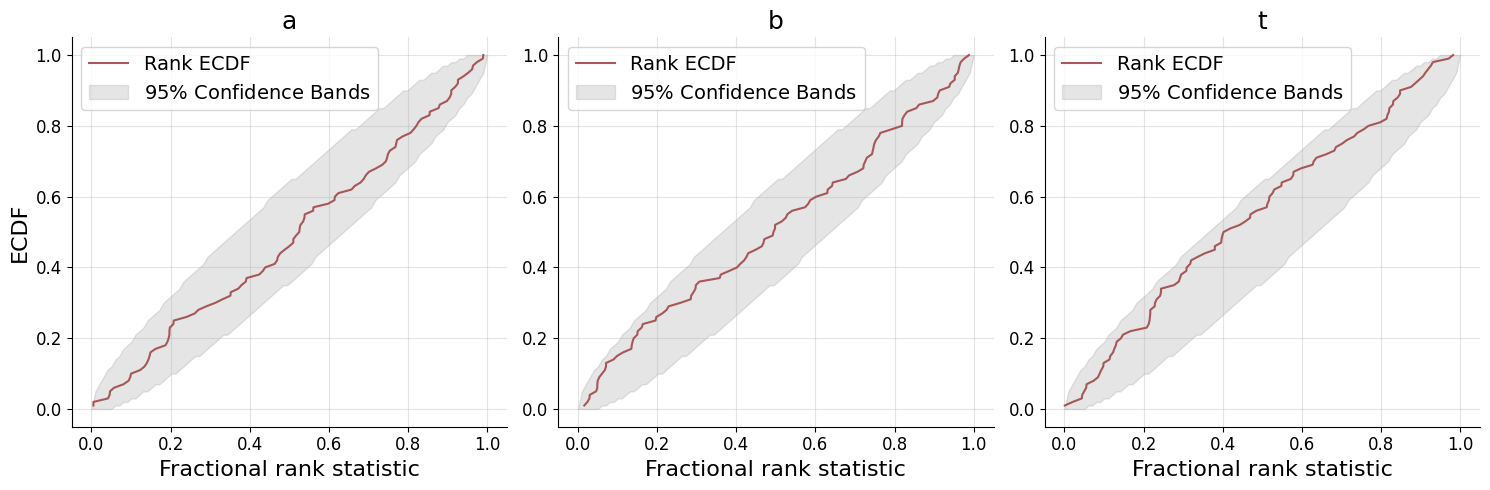

In [120]:
# # Create ECDF plot
f = diag.plot_sbc_ecdf(post_samples, 
                       validation_sims["parameters"], 
                       param_names=prior.param_names, 
                       difference=False, stacked=False)

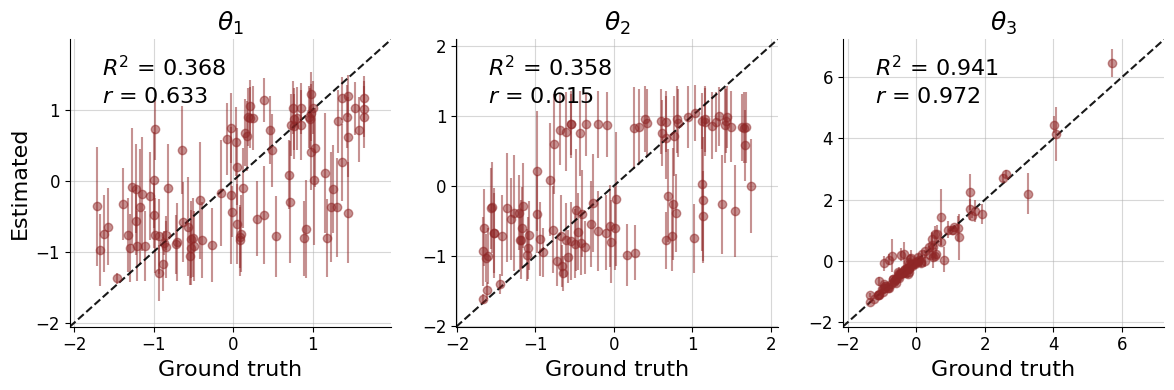

In [121]:
fig = diag.plot_recovery(post_samples, validation_sims["parameters"])

### 1. Posterior estimation:

In [137]:
with open('../data/true_likes.pkl', 'rb') as f:
    true_likes = pickle.load(f)

In [138]:
# Format data into a 3D array of shape (1, n_time_steps, 1) and perform log transform
obs_data = np.log1p(np.histogram(true_likes, bins=100)[0])[np.newaxis, :, np.newaxis].astype(np.float32)
# obs_data = np.log1p(true_likes)[0])[np.newaxis, :, np.newaxis].astype(np.float32)

In [139]:
# Obtain 500 posterior draws given real data
post_samples_ = amortizer.sample({"summary_conditions": obs_data}, 1000)

# Undo standardization to get parameters on their original (unstandardized) scales
post_samples_ = prior_means + post_samples_ * prior_stds

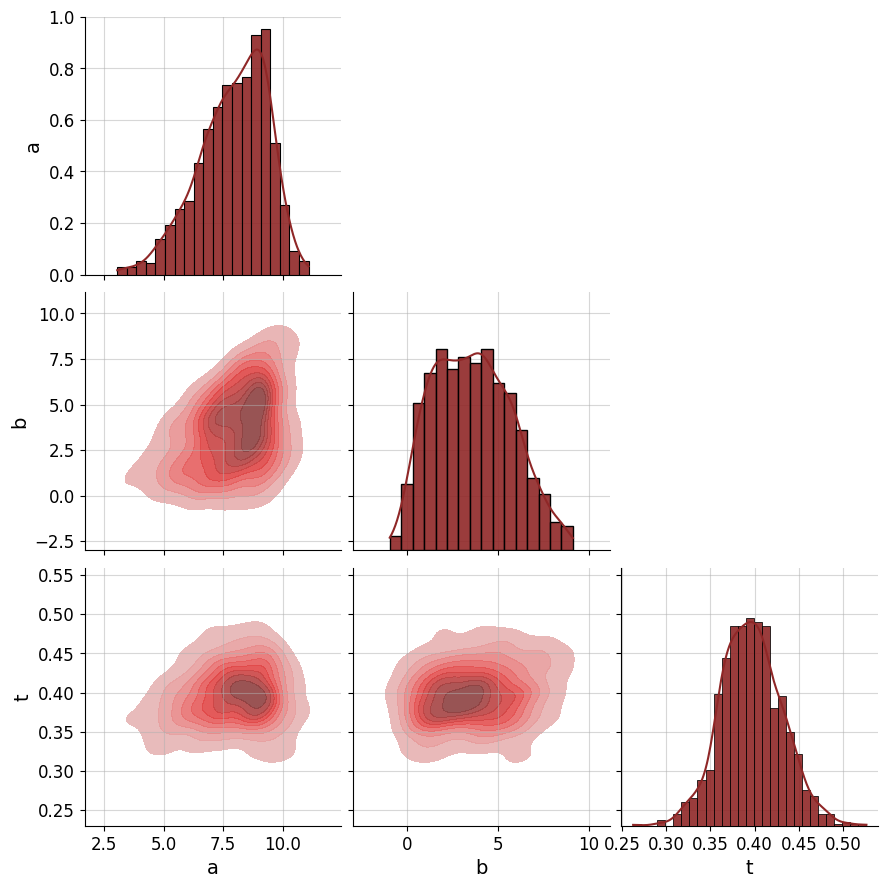

In [140]:
f = diag.plot_posterior_2d(post_samples_, param_names=prior.param_names)

In [141]:
# # Generate some validation data
# validation_sims = trainer.configurator(model(batch_size=10))

# # Generate posterior draws for all simulations
# post_samples = amortizer.sample(validation_sims, n_samples=100)

In [142]:
# f = diag.plot_recovery(post_samples, validation_sims["parameters"], param_names=prior.param_names)

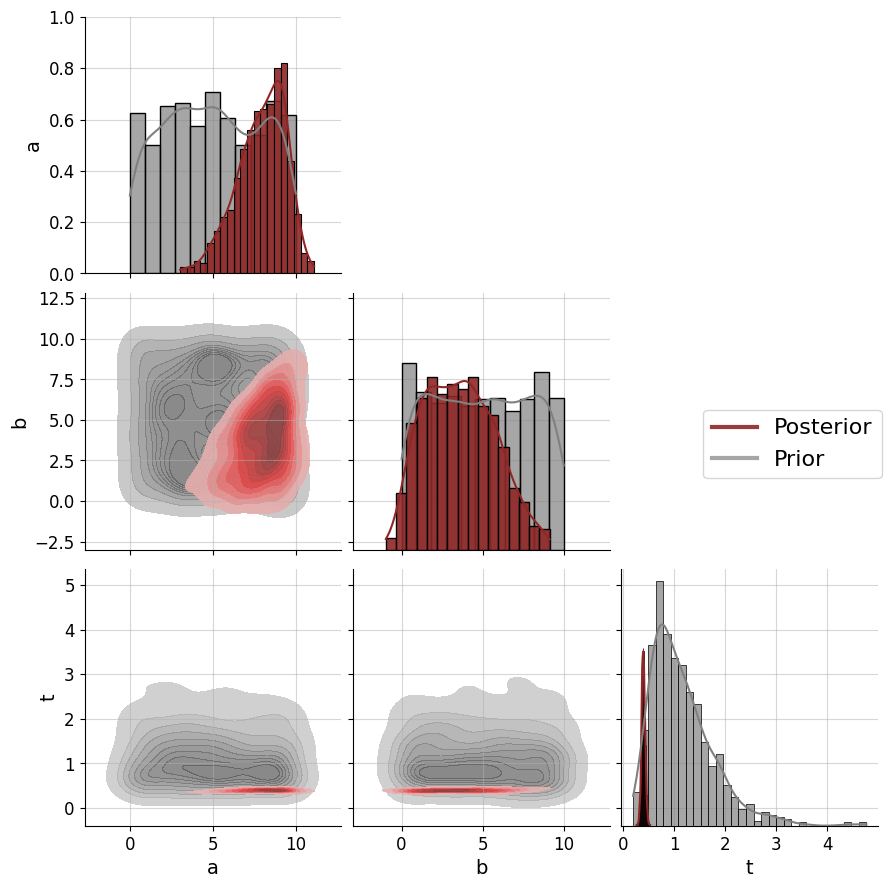

In [143]:
f = diag.plot_posterior_2d(post_samples_, prior=prior)

In [173]:
ps = ['α', 'β', 'τ']
table_data = []
for _ in range(3):
    row = [ps[_], np.mean(post_samples_[:, _]).round(3), az.hdi(post_samples_[:, _], hdi_prob=0.95).round(3)]
    table_data.append(row)

table_headers = ['Parameter', 'Mean', 'HDI']
latex_table = tabulate(table_data, headers=table_headers, tablefmt='latex')
print(latex_table)

\begin{tabular}{lrl}
\hline
 Parameter   &   Mean & HDI             \\
\hline
 α           &  7.927 & [ 5.018 10.43 ] \\
 β           &  3.594 & [-0.118  7.491] \\
 τ           &  0.396 & [0.326 0.464]   \\
\hline
\end{tabular}


In [ ]:
# estimate mean and 95% credible interval 

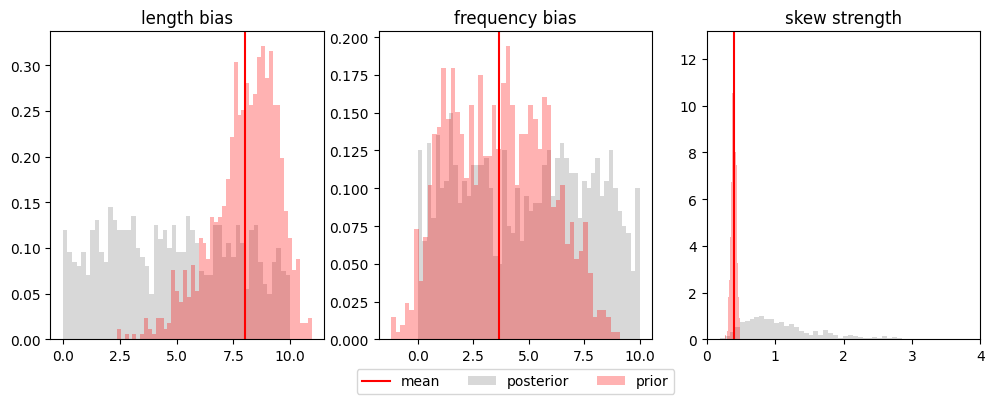

In [114]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].hist(np.random.uniform(0, 10, 1000), bins=50, alpha=0.3, color='grey', density=True)
axs[1].hist(np.random.uniform(0, 10, 1000), bins=50, alpha=0.3, color='grey', density=True)
axs[2].hist(np.random.lognormal(0, sigma=0.5, size=1000), bins=50, alpha=0.3, color='grey', density=True)

# Plot posteriors
axs[0].hist(post_samples_[:, 0], bins=50, alpha=0.3, color='red', density=True)
axs[1].hist(post_samples_[:, 1], bins=50, alpha=0.3, color='red', density=True)
axs[2].hist(post_samples_[:, 2], bins=50, alpha=0.3, color='red', density=True)

# plot posterior means
axs[0].axvline(post_samples_[:, 0].mean(), color='red')
axs[1].axvline(post_samples_[:, 1].mean(), color='red')
axs[2].axvline(post_samples_[:, 2].mean(), color='red')

# Set xlim for [2] to 0, 4
axs[2].set_xlim(0, 4)

# Set titles
axs[0].set_title('length bias')
axs[1].set_title('frequency bias')
axs[2].set_title('skew strength')

# Add legend below the subplots
plt.legend(['mean', 'posterior', 'prior'], bbox_to_anchor=(-0.7, -0.2), loc='lower center', ncol=3)

# Show the plot
plt.show()

In [126]:
# Perform PCA
pca = PCA(n_components=2, whiten=True)
pca_result = pca.fit_transform(gen_data['sim_data'])

In [127]:
true_hist = np.histogram(true_likes, bins=100)[0]
true_hist = true_hist.reshape(1, -1)

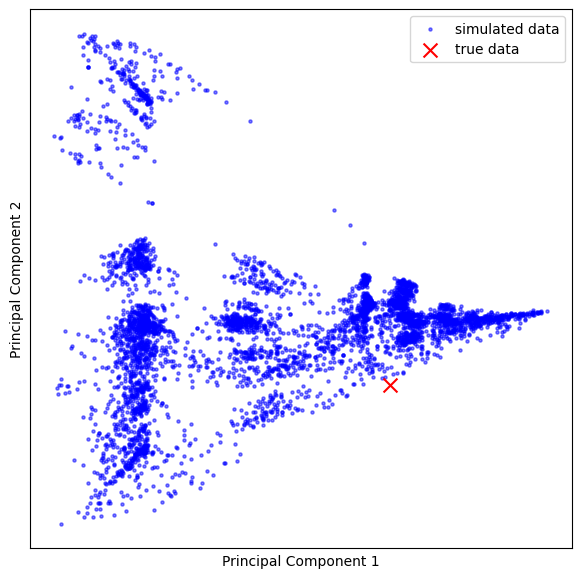

In [128]:
# Plot PCA
plt.figure(figsize=(7, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], 
            s=5, color = 'blue', 
            alpha=0.5, label='simulated data')
plt.scatter(pca.transform(true_hist)[0, 0],
             pca.transform(true_hist)[0, 1], 
             s=100, color='red', marker='x', 
             label='true data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# remove ticks
plt.tick_params(axis='both', which='both', 
                bottom=False, left=False, 
                labelbottom=False, labelleft=False)
plt.legend()
plt.show()